# Options Pricing Using Machine Learning

In [85]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [118]:
# Create a Ticker object
apple_ticker = yf.Ticker("AAPL")

# Fetch historical market data
apple_historical_data = apple_ticker.history(period="1y")  # data for the last year
print("Historical Data:")
print(apple_historical_data.head(5))

# Fetch basic financials
financials = apple_ticker.financials
print("\nFinancials:")
print(financials)

# Fetch stock actions like dividends and splits
actions = ticker.actions
print("\nStock Actions:")
print(actions)


Historical Data:
                                 Open        High         Low       Close  \
Date                                                                        
2023-12-20 00:00:00-05:00  195.940089  196.716285  193.880188  193.880188   
2023-12-21 00:00:00-05:00  195.143987  196.119205  192.556656  193.730896   
2023-12-22 00:00:00-05:00  194.228458  194.457347  192.029240  192.656174   
2023-12-26 00:00:00-05:00  192.666139  192.944773  191.889943  192.108871   
2023-12-27 00:00:00-05:00  191.551588  192.556659  190.158404  192.208359   

                             Volume  Dividends  Stock Splits  
Date                                                          
2023-12-20 00:00:00-05:00  52242800        0.0           0.0  
2023-12-21 00:00:00-05:00  46482500        0.0           0.0  
2023-12-22 00:00:00-05:00  37122800        0.0           0.0  
2023-12-26 00:00:00-05:00  28919300        0.0           0.0  
2023-12-27 00:00:00-05:00  48087700        0.0           0.0  

F

In [128]:
# Fetch risk-free interest rate
rfir_array = yf.Ticker("^IRX").history(period="1y").Close

rfir = np.mean(rfir_array.values)

print(rfir)


4.983320130661071


In [35]:
apple=pd.DataFrame(apple_historical_data)
apple

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-12-20 00:00:00-05:00,195.940089,196.716285,193.880188,193.880188,52242800,0.0,0.0
2023-12-21 00:00:00-05:00,195.143971,196.119189,192.556641,193.730881,46482500,0.0,0.0
2023-12-22 00:00:00-05:00,194.228458,194.457347,192.029240,192.656174,37122800,0.0,0.0
2023-12-26 00:00:00-05:00,192.666108,192.944742,191.889912,192.108841,28919300,0.0,0.0
2023-12-27 00:00:00-05:00,191.551603,192.556674,190.158419,192.208374,48087700,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-13 00:00:00-05:00,247.820007,249.289993,246.240005,248.130005,33155300,0.0,0.0
2024-12-16 00:00:00-05:00,247.990005,251.380005,247.649994,251.039993,51694800,0.0,0.0
2024-12-17 00:00:00-05:00,250.080002,253.830002,249.779999,253.479996,51356400,0.0,0.0


In [27]:
# a baseline for predicting volatility
"""
    This function takes in a dataframe df of stock prices, a metric such as 'Close',
    and a number n which is the length of array of volatilities we want.
    The function computes this by breaking the dataframe into n pieces and then
    computing volatility on each interval.
"""

""" def volatilities(df, metric, n):

    sigmas = []
    interval = len(df)//n
    for i in range(1,n):
        sigmas.append(np.var(df[(i-1)*interval:i*interval][metric]))
    sigmas.append(np.var(df[(n-1)*interval:n*interval][metric]))
    return sigmas """

def volatilities(df, n=30):
    """
    This function takes in a dataframe df of stock prices in yf format
    and a number n which is the length of array (equal to # of days) of 
    volatilities we want.  The function computes volatility per day by
    taking the previous n datapoints (default is set to n = 30 days)
    and then computing the standard deviation in closing price on each
    interval (intraday changes can improve this measure).

    Typical range for n is 10 to 365 trading days.

    Sigma array provides data for original df (with zero volatility for
    first n days)
    """
    sigmas = []
    n_chunks = len(df)//n
    for i in range(n,len(df)):
        sigmas.append(np.var(df[i-n:i]['Close']))
    sigmas = np.insert(sigmas, 0, np.full((n), 0))
    return sigmas


In [28]:
volatilities(apple)

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  21.60587995,  19.99602173,
        18.88068705,  17.70623614,  16.8815965 ,  16.16030815,
        15.38539565,  14.39357695,  13.88150515,  14.10351004,
        14.13937191,  13.91175934,  13.66093195,  14.37584661,
        14.47206879,  15.16653132,  16.25152027,  16.83522093,
        17.43072282,  18.02624627,  19.58711824,  22.9170535 ,
        28.78155995,  33.56558134,  37.49135703,  38.78269534,
        38.77605239,  38.13733069,  40.10343363,  41.7296889 ,
        42.41807685,  42.6271392 ,  40.96097505,  37.74

Apple announced their new M4 chips on 7 May, 2024. That seems to be about when the prices started to rise and maybe why the middle volatility is so large. These M4 chips use a different kind of architecture from Intel.

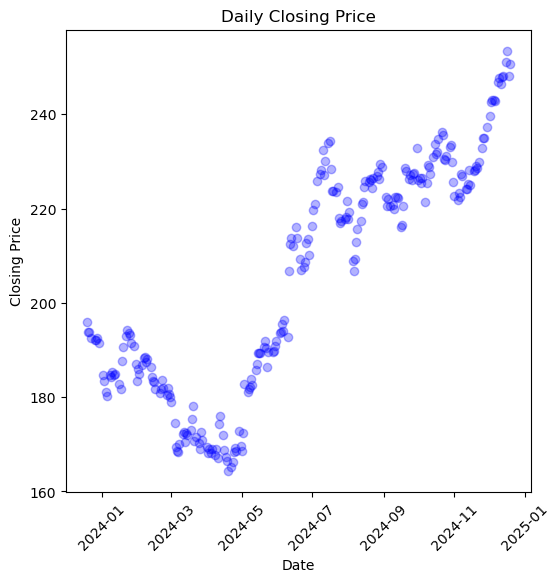

In [29]:
# Plot daily closing price
plt.figure(figsize=(6, 6))
plt.scatter(apple.index, apple['Close'], color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Daily Closing Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

In [93]:
# Preprocessing and feature engineering

expiration_dates = apple_ticker.options

apple_calls = pd.DataFrame()
apple_puts = pd.DataFrame()

# Download the options data for Apple for all expiration dates, put into 1 table
# Add columns for expiration date and time to expiration
for i in expiration_dates:
    apple_options = apple_ticker.option_chain(i)

    # Separate the calls and puts data
    new_call = pd.DataFrame(apple_options.calls)
    new_call.insert(0, 'Expiration_Date', np.full(len(new_call), pd.to_datetime(i)))
    new_call=new_call.dropna()
    new_call['TimeToExpiration'] = (pd.to_datetime(i) - pd.Timestamp.now()).days
    apple_calls = pd.concat([apple_calls, new_call])
    new_put = pd.DataFrame(apple_options.puts)
    new_put.insert(0, 'Expiration_Date', np.full(len(new_put), pd.to_datetime(i)))
    new_put=new_put.dropna()
    new_put['TimeToExpiration'] = (pd.to_datetime(i) - pd.Timestamp.now()).days
    apple_puts = pd.concat([apple_puts, new_put])
    
# Eliminate outliers in implied volatility

apple_calls = apple_calls[abs(apple_calls.impliedVolatility)<=apple_calls.impliedVolatility.std()*3]

In [94]:
apple_calls

,Expiration_Date,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,TimeToExpiration
3,2024-12-20,AAPL241220C00020000,2024-08-02 14:52:49+00:00,20.0,203.60,207.85,210.45,0.000000,0.000000,1.0,1,0.000010,True,REGULAR,USD,0
4,2024-12-20,AAPL241220C00030000,2024-11-01 16:54:22+00:00,30.0,192.45,212.80,213.70,0.000000,0.000000,2.0,0,0.000010,True,REGULAR,USD,0
12,2024-12-20,AAPL241220C00085000,2024-05-07 19:29:13+00:00,85.0,99.84,111.30,112.95,0.000000,0.000000,5.0,218,0.000010,True,REGULAR,USD,0
16,2024-12-20,AAPL241220C00105000,2024-11-01 17:09:02+00:00,105.0,117.60,138.00,138.65,0.000000,0.000000,4.0,67,0.000010,True,REGULAR,USD,0
18,2024-12-20,AAPL241220C00115000,2024-12-19 19:02:54+00:00,115.0,136.20,134.45,135.10,-1.800003,-1.304350,7.0,516,6.804689,True,REGULAR,USD,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,2027-01-15,AAPL270115C00410000,2024-12-19 15:17:03+00:00,410.0,4.88,2.83,5.30,-0.120000,-2.399998,2.0,65,0.262214,False,REGULAR,USD,756
56,2027-01-15,AAPL270115C00420000,2024-12-19 14:36:43+00:00,420.0,4.22,3.70,4.60,0.020000,0.476190,1.0,3261,0.261177,False,REGULAR,USD,756
57,2027-01-15,AAPL270115C00430000,2024-12-17 14:43:51+00:00,430.0,3.70,2.84,4.35,0.000000,0.000000,2.0,23,0.265663,False,REGULAR,USD,756
58,2027-01-15,AAPL270115C00440000,2024-12-18 17:43:20+00:00,440.0,3.38,2.98,3.55,0.000000,0.000000,1.0,171,0.260841,False,REGULAR,USD,756


In [95]:
keep_cols = ['strike', 'lastPrice', 'bid', 'ask', 'percentChange', 'TimeToExpiration', 'impliedVolatility']
apple = apple_calls[keep_cols]

In [116]:
features = ['strike', 'lastPrice', 'TimeToExpiration', 'bid', 'ask', ]

In [129]:
X_train, X_test, y_train, y_test = train_test_split(apple[features], apple.impliedVolatility, test_size=0.2, shuffle=True)

In [138]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

rf = RandomForestRegressor(n_estimators=100, max_depth=50)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(mean_squared_error(y_test, y_pred))

0.9163211529396007


/Users/gabbyhuckabee/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


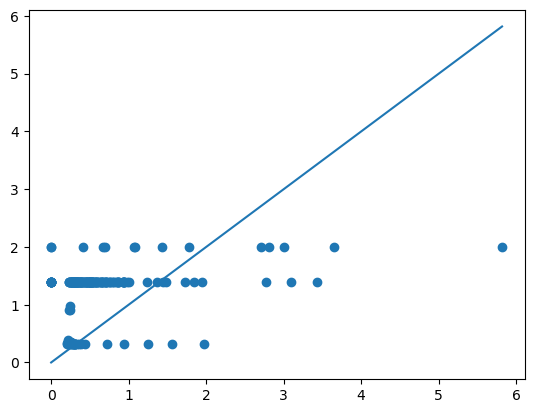

In [139]:
plt.scatter(y_test, y_pred)
plt.plot(np.linspace(np.amin(y_test), np.amax(y_test), num=10), np.linspace(np.amin(y_test), np.amax(y_test), num=10))
plt.show()

In [30]:
# Define the ticker symbol
ticker_symbol = "TSLA" # Tesla

# Create a Ticker object
ticker = yf.Ticker(ticker_symbol)

# Fetch historical market data
historical_data = ticker.history(period="1y")  # data for the last year
tesla = pd.DataFrame(historical_data)

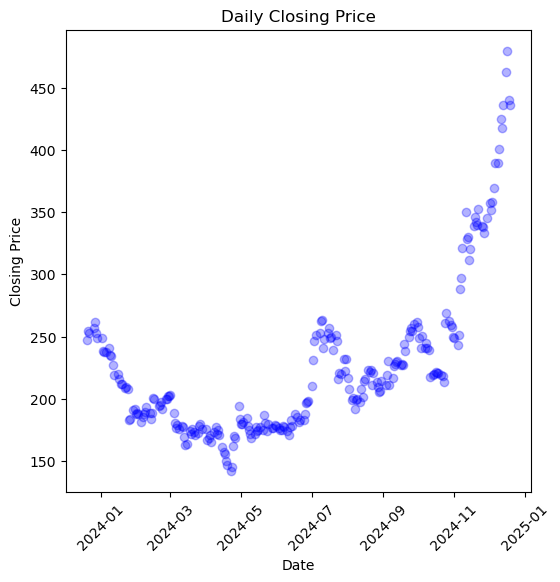

In [31]:
# Plot daily closing price
plt.figure(figsize=(6, 6))
plt.scatter(tesla.index, tesla['Close'], color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Daily Closing Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

In [32]:
volatilities(tesla)

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,  612.03139079,  646.29901475,
        645.46928204,  633.86887984,  598.53878911,  532.60306768,
        489.50601262,  456.45379748,  408.38393187,  371.42429835,
        332.56909123,  293.52548332,  242.15782567,  200.02712956,
        158.26651014,  127.7696063 ,  110.87517081,   92.39936962,
         79.84651088,   72.02268915,   62.1448174 ,   59.08751724,
         57.53286753,   53.36013045,   58.95018954,   62.51742228,
         67.62779592,   80.64788933,  103.27537406,  122.72646

### Medium article

Below is some stuff from an [article](https://theaiquant.medium.com/mastering-option-pricing-with-machine-learning-a-practical-guide-to-valuing-real-options-data-1ef58c8d3a39).

In [2]:
# Define the ticker symbol for JPMorgan Chase & Co.
ticker_symbol = 'JPM'

# Initialize the yfinance Ticker object for JPM
jpm_ticker = yf.Ticker(ticker_symbol)

# Get available expiration dates
expiration_dates = jpm_ticker.options

# Choose an expiration date that exists in the list of available expiration dates
# For the purpose of this example, let's choose the first available expiration date
expiration_date = expiration_dates[0]

# Download the options data for JPM for the chosen expiration date
jpm_options = jpm_ticker.option_chain(expiration_date)

# Separate the calls and puts data
jpm_calls = jpm_options.calls
jpm_puts = jpm_options.puts

# Display the first few rows of the calls data
print(jpm_calls.head())

       contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0  JPM241220C00085000 2024-10-07 13:53:59+00:00    85.0     128.37  151.60   
1  JPM241220C00090000 2024-06-24 19:21:11+00:00    90.0     109.15  118.65   
2  JPM241220C00095000 2024-09-12 13:52:01+00:00    95.0     111.15  127.60   
3  JPM241220C00100000 2024-11-08 18:51:51+00:00   100.0     139.07  141.10   
4  JPM241220C00105000 2024-12-02 18:35:14+00:00   105.0     142.05  132.45   

      ask  change  percentChange  volume  openInterest  impliedVolatility  \
0  152.30     0.0            0.0     1.0             1            0.00001   
1  121.40     0.0            0.0     2.0             1            0.00001   
2  129.90     0.0            0.0     NaN             0            0.00001   
3  144.95     0.0            0.0     3.0             3            6.43799   
4  134.75     0.0            0.0     2.0             2            3.48047   

   inTheMoney contractSize currency  
0        True      REGULAR    

In [8]:
expiration_dates

('2024-12-20',
 '2024-12-27',
 '2025-01-03',
 '2025-01-10',
 '2025-01-17',
 '2025-01-24',
 '2025-01-31',
 '2025-02-21',
 '2025-03-21',
 '2025-04-17',
 '2025-06-20',
 '2025-07-18',
 '2025-08-15',
 '2025-09-19',
 '2025-12-19',
 '2026-01-16',
 '2026-12-18',
 '2027-01-15')

In [3]:
# Preprocessing and feature engineering for JPM calls data
# Assume similar steps for puts data and other assets

# Drop rows with missing values
jpm_calls_cleaned = jpm_calls.dropna()

# Feature engineering: calculate moneyness, time to expiration and other relevant features
# Assuming that 'lastPrice' represents the current stock price
jpm_calls_cleaned['Moneyness'] = jpm_calls_cleaned['lastPrice'] / jpm_calls_cleaned['strike']
jpm_calls_cleaned['TimeToExpiration'] = (pd.to_datetime(expiration_date) - pd.Timestamp.now()).days

# Display the first few rows of the processed calls data
print(jpm_calls_cleaned.head())

       contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0  JPM241220C00085000 2024-10-07 13:53:59+00:00    85.0     128.37  151.60   
1  JPM241220C00090000 2024-06-24 19:21:11+00:00    90.0     109.15  118.65   
3  JPM241220C00100000 2024-11-08 18:51:51+00:00   100.0     139.07  141.10   
4  JPM241220C00105000 2024-12-02 18:35:14+00:00   105.0     142.05  132.45   
5  JPM241220C00110000 2024-11-20 15:38:13+00:00   110.0     130.34  127.45   

      ask  change  percentChange  volume  openInterest  impliedVolatility  \
0  152.30     0.0            0.0     1.0             1           0.000010   
1  121.40     0.0            0.0     2.0             1           0.000010   
3  144.95     0.0            0.0     3.0             3           6.437990   
4  134.75     0.0            0.0     2.0             2           3.480470   
5  128.75     0.0            0.0     1.0             8           3.531251   

   inTheMoney contractSize currency  Moneyness  TimeToExpiration  
0

/var/folders/4l/xdk1tfxx7jbd3zsydcl3t4vh0000gn/T/ipykernel_93772/1641090000.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jpm_calls_cleaned['Moneyness'] = jpm_calls_cleaned['lastPrice'] / jpm_calls_cleaned['strike']
/var/folders/4l/xdk1tfxx7jbd3zsydcl3t4vh0000gn/T/ipykernel_93772/1641090000.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jpm_calls_cleaned['TimeToExpiration'] = (pd.to_datetime(expiration_date) - pd.Timestamp.now()).days


Text(0, 0.5, 'Frequency')

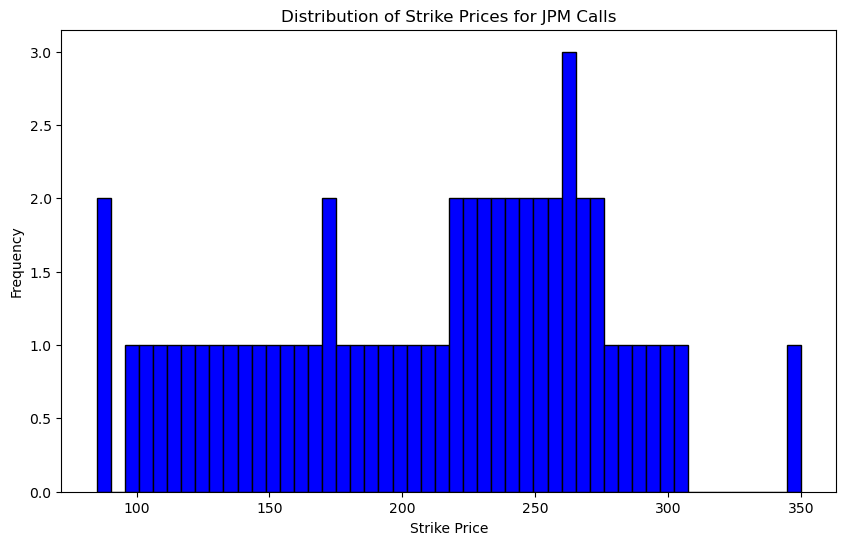

In [4]:
# Plot the distribution of strike prices for JPM calls
plt.figure(figsize=(10, 6))
plt.hist(jpm_calls_cleaned['strike'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Strike Prices for JPM Calls')
plt.xlabel('Strike Price')
plt.ylabel('Frequency')

In [10]:
jpm_calls_cleaned.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Moneyness,TimeToExpiration
0,JPM241220C00085000,2024-10-07 13:53:59+00:00,85.0,128.37,151.60,152.30,0.0,0.0,1.0,1,0.000010,True,REGULAR,USD,1.510235,2
1,JPM241220C00090000,2024-06-24 19:21:11+00:00,90.0,109.15,118.65,121.40,0.0,0.0,2.0,1,0.000010,True,REGULAR,USD,1.212778,2
3,JPM241220C00100000,2024-11-08 18:51:51+00:00,100.0,139.07,141.10,144.95,0.0,0.0,3.0,3,6.437990,True,REGULAR,USD,1.390700,2
4,JPM241220C00105000,2024-12-02 18:35:14+00:00,105.0,142.05,132.45,134.75,0.0,0.0,2.0,2,3.480470,True,REGULAR,USD,1.352857,2
5,JPM241220C00110000,2024-11-20 15:38:13+00:00,110.0,130.34,127.45,128.75,0.0,0.0,1.0,8,3.531251,True,REGULAR,USD,1.184909,2


In [20]:
# Prepare the data for training the machine learning model
X = jpm_calls_cleaned[['Moneyness','TimeToExpiration', 'impliedVolatility']]
y = jpm_calls_cleaned['lastPrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=200,random_state=30)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Predict option prices on the test set
y_pred = rf_model.predict(X_test_scaled)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 104.45422981500006


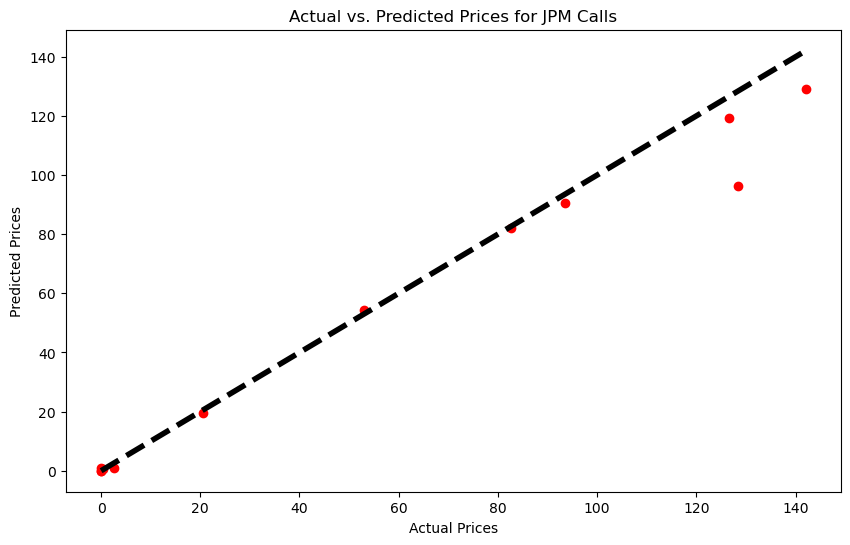

In [21]:
# Plot actual vs. predicted prices for JPM calls
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='red')
plt.title('Actual vs. Predicted Prices for JPM Calls')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)

Text(0, 0.5, 'Feature')

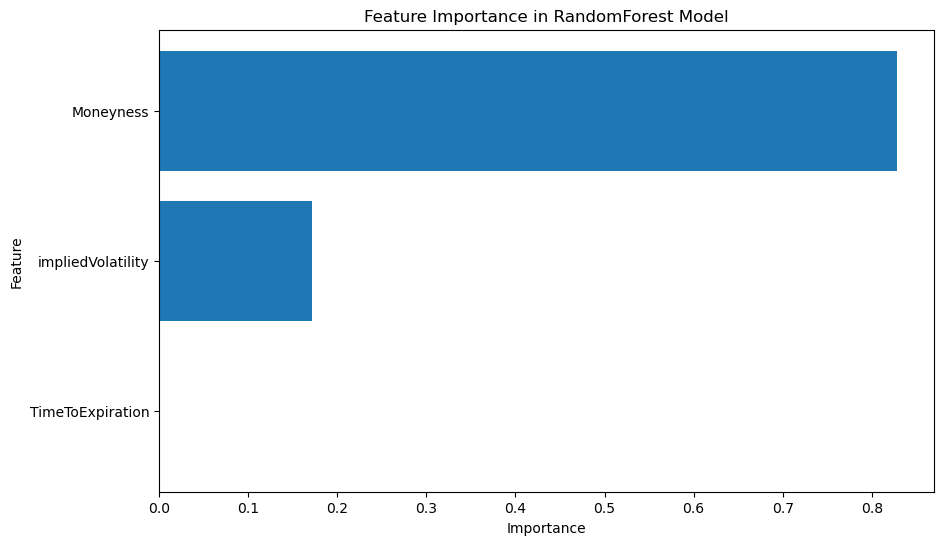

In [22]:
# Plot feature importance
feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance in RandomForest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')